Initial Data Preview:
   Unnamed: 0         ID          Name               Role  \
0           0  brenbr359   brent brown    product manager   
1           1  jameay305   james ayala  software engineer   
2           2  scotri565  scott rivera      data engineer   
3           3  emilke232   emily kelly        ui engineer   
4           4  ashlra638    ashley ray     data scientist   

                                          Transcript  \
0  product manager interview transcript\n\ninterv...   
1  software engineer interview transcript\n\ninte...   
2  here is a simulated interview for scott rivera...   
3  interview transcript: emily kelly for ui engin...   
4  data scientist interview transcript\n\ncompany...   

                                              Resume decision  \
0  here's a sample resume for brent brown applyin...   select   
1  here's a sample resume for james ayala applyin...   select   
2  here's a sample resume for scott rivera applyi...   reject   
3  here's a sa

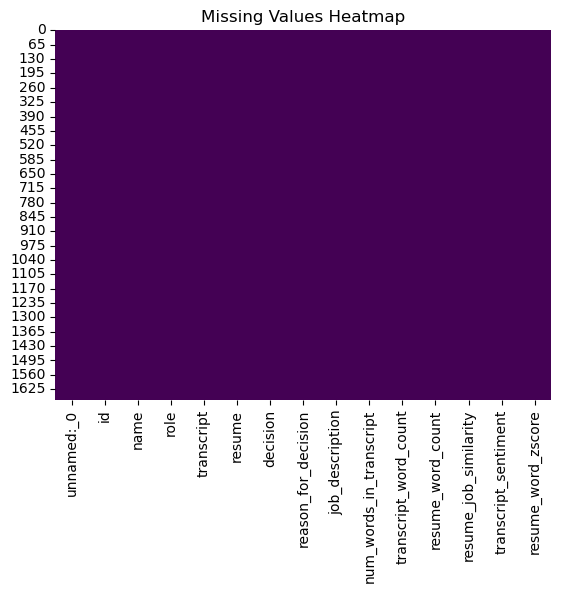

Non-numeric columns: Index(['id', 'name', 'role', 'transcript', 'resume', 'decision',
       'reason_for_decision', 'job_description'],
      dtype='object')


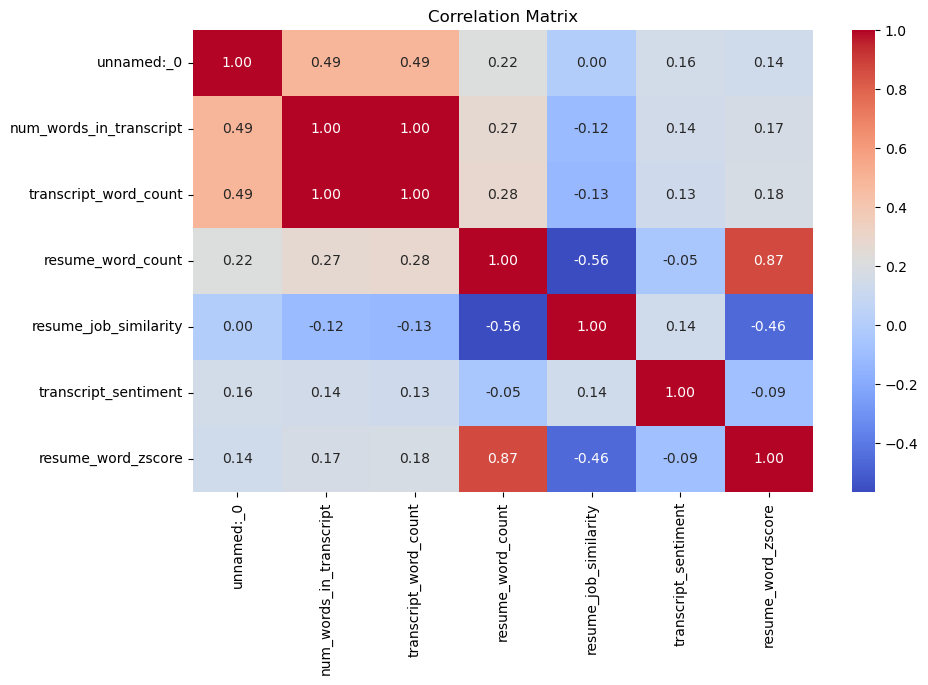

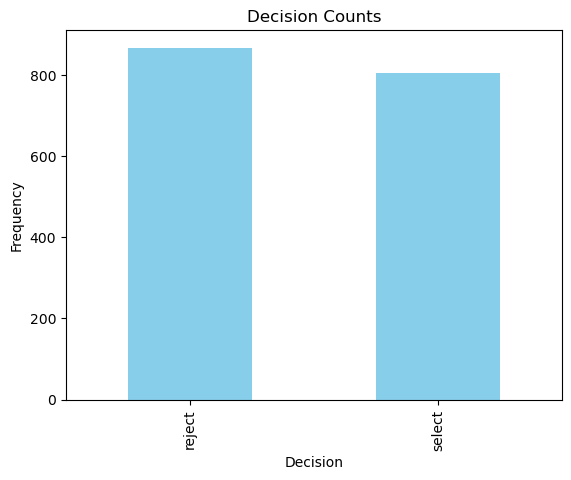

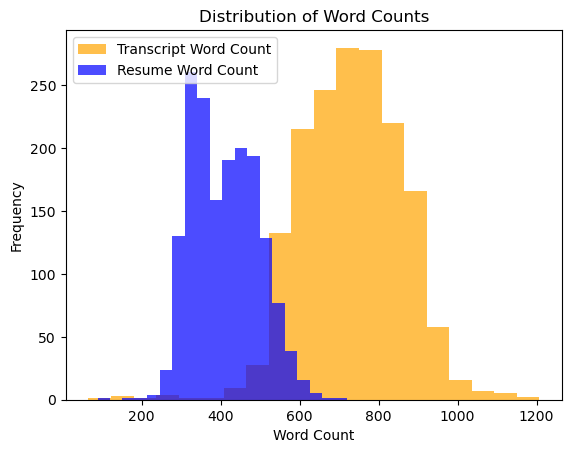

C:\Users\bjeev\AppData\Local\Temp\ipykernel_6968\2824309622.py:130: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='decision', y='resume_word_count', data=df, palette='Set2')


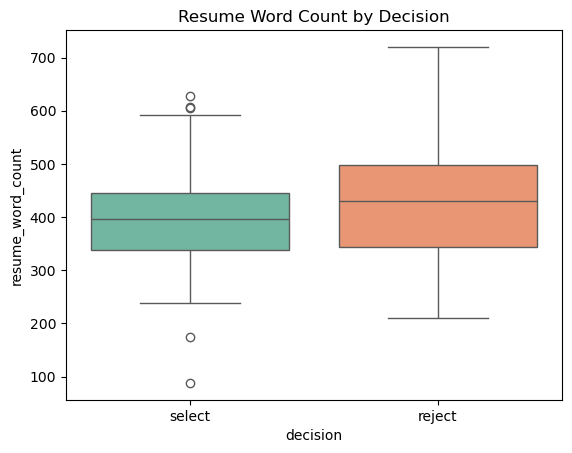

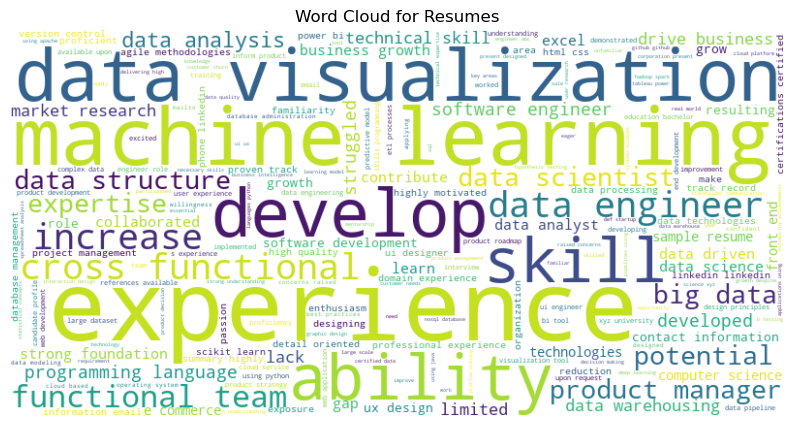

Cleaned dataset saved to Recruiting_Cleaned.xlsx


In [3]:
# Step 1: Import Dependencies
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from textblob import TextBlob
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

# Step 2: Load the Dataset
file_path = "C:\\Users\\bjeev\\Downloads\\Aidata.xlsx"  # Replace with your file path
df = pd.read_excel(file_path)

# Step 3: Initial Overview of Data
print("Initial Data Preview:")
print(df.head())
print("\nData Summary:")
print(df.info())

# ---------------------------------------
# Step 4: Data Cleaning
# ---------------------------------------

# Standardize column names
df.columns = df.columns.str.lower().str.replace(' ', '_')

# Fill missing values for text fields
df.fillna({'transcript': '', 'resume': '', 'job_description': '', 'reason_for_decision': 'Unknown'}, inplace=True)

# Drop duplicate rows based on 'id'
df.drop_duplicates(subset='id', inplace=True)

# Clean text fields (remove special characters, numbers, etc.)
import re
def clean_text(text):
    text = re.sub(r'\W+', ' ', text)  # Remove special characters
    text = re.sub(r'\d+', '', text)  # Remove numbers
    return text.strip().lower()

df['transcript'] = df['transcript'].apply(clean_text)
df['resume'] = df['resume'].apply(clean_text)
df['job_description'] = df['job_description'].apply(clean_text)

# ---------------------------------------
# Step 5: Feature Engineering
# ---------------------------------------

# Add word count features
df['transcript_word_count'] = df['transcript'].apply(lambda x: len(x.split()))
df['resume_word_count'] = df['resume'].apply(lambda x: len(x.split()))

# Calculate resume-job similarity using TF-IDF
def compute_similarity(resume, job_description):
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform([resume, job_description])
    return cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])[0][0]

df['resume_job_similarity'] = df.apply(
    lambda row: compute_similarity(row['resume'], row['job_description']), axis=1
)

# Sentiment analysis for transcripts
df['transcript_sentiment'] = df['transcript'].apply(lambda x: TextBlob(x).sentiment.polarity)

# ---------------------------------------
# Step 6: Advanced Cleaning (Group-Based)
# ---------------------------------------

# Fill missing word counts with median values grouped by 'role'
if 'role' in df.columns:
    df['transcript_word_count'] = df.groupby('role')['transcript_word_count'].transform(lambda x: x.fillna(x.median()))

# Detect outliers in 'resume_word_count' using z-scores
if 'role' in df.columns:
    df['resume_word_zscore'] = df.groupby('role')['resume_word_count'].transform(lambda x: zscore(x, nan_policy='omit'))
    outliers = df[df['resume_word_zscore'] > 3]
    print("\nOutliers Detected:\n", outliers)


# ---------------------------------------
# Step 7: Exploratory Data Analysis (EDA)
# ---------------------------------------

# 1. Summary Statistics
print("\nSummary Statistics:")
print(df.describe())

# 2. Missing Values Heatmap
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values Heatmap")
plt.show()

# 3. Correlation Analysis
# Identify non-numeric columns
non_numeric_columns = df.select_dtypes(exclude=[np.number]).columns
print("Non-numeric columns:", non_numeric_columns)

# Compute correlation matrix excluding non-numeric columns
correlation_matrix = df.corr(numeric_only=True)

# Visualize the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()


# 4. Decision Counts Visualization
if 'decision' in df.columns:
    decision_counts = df['decision'].value_counts()
    decision_counts.plot(kind='bar', color='skyblue')
    plt.title("Decision Counts")
    plt.xlabel("Decision")
    plt.ylabel("Frequency")
    plt.show()

# 5. Distribution of Word Counts
plt.hist(df['transcript_word_count'], bins=20, alpha=0.7, label='Transcript Word Count', color='orange')
plt.hist(df['resume_word_count'], bins=20, alpha=0.7, label='Resume Word Count', color='blue')
plt.title("Distribution of Word Counts")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# 6. Boxplot for Resume Word Counts by Decision
if 'decision' in df.columns:
    sns.boxplot(x='decision', y='resume_word_count', data=df, palette='Set2')
    plt.title("Resume Word Count by Decision")
    plt.show()

# 7. Word Cloud for Resumes
resume_text = ' '.join(df['resume'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(resume_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Resumes")
plt.show()

# ---------------------------------------
# Step 8: Save Cleaned Dataset
# ---------------------------------------

cleaned_file_path = 'Recruiting_Cleaned.xlsx'
df.to_excel(cleaned_file_path, index=False)
print(f"Cleaned dataset saved to {cleaned_file_path}")